**Introduction**

With increasing usage of mobile messaging, customer messages presented to financial institutions often contain scams, phishing, or fraudulent content. Detection of such messages needs to be automatic to protect customers and reduce operational risk. In this project, natural language processing (NLP) and machine learning techniques have been employed for the classification of SMS messages as no-scam (ham) or scam (spam).
SMS Spam Collection Dataset (https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)


**Why I Picked This Dataset – Business Relevance**

People text their banks, get alerts about their accounts, and scammers know how to do it too. SMS has basically turned into a playground for phishing, sketchy links, and those “your account is locked, click here” etc..

If you’re a business dealing with sensitive info, you can’t just sit around checking messages by hand. That’s slow, expensive, and let’s accept it, human cant work with zero error.

Why the SMS Spam Collection Dataset? :

* It’s straight-up what real customers see in their texts—plenty of legit stuff, but also a buffet of spam.
* Spam vs. not-spam? Super clear. simple, solid evaluation.
* It’s perfect for testing out real-world stuff, like:
  * Spotting sketchy texts right as they come in.
  * Keeping customers from even seeing scams.
* Plus, it’s open, clean, and everyone uses it,less time cleaning up weird data, more time actually building something useful.

Bottom line, this dataset just nails what businesses care about: stopping fraud, ticking those compliance boxes, and automating the headache out of spam detection.

##**Step 1: Import Required Libraries**

We begin by importing the necessary libraries for data handling, preprocessing, model training, and evaluation.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

##**Step 2: Load and Explore Dataset**

We load the dataset and explore basic statistics such as class distribution.

I inspected the dataset and there were completely empty extra columns. Therefore, applying the classic data loading and cleaning way is not applicable. I gave meaningful names and also convert to numeric.




In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


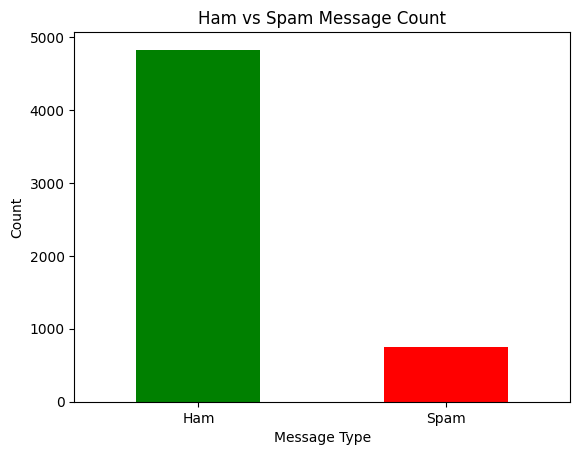

In [3]:
df['label'].value_counts().plot(kind='bar', color=['green', 'red'], title='Ham vs Spam Message Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'], rotation=0)
plt.ylabel("Count")
plt.xlabel("Message Type")
plt.show()

In [ ]:
#WordCloud Visualization

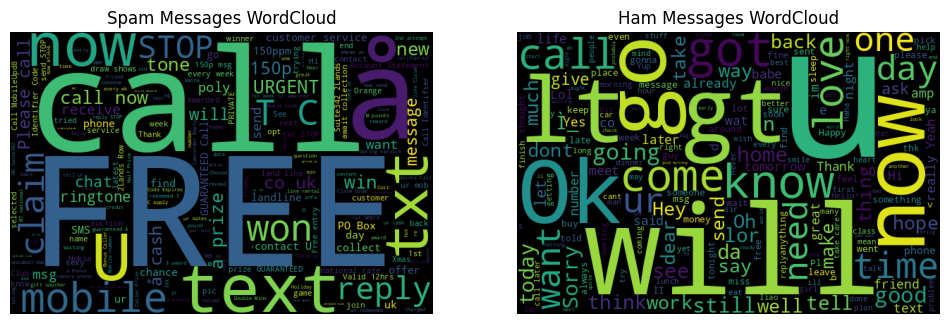

In [4]:
spam_words = ' '.join(df[df['label']==1]['message'])
ham_words = ' '.join(df[df['label']==0]['message'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400).generate(spam_words))
plt.axis('off')
plt.title('Spam Messages WordCloud')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(ham_words))
plt.axis('off')
plt.title('Ham Messages WordCloud')
plt.show()

## **Step 3: Text Cleaning**
Here we lowercase all text, tokenize it, and remove stopwords and punctuation to prepare for modeling.

In [5]:
def simple_clean(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return " ".join([t for t in tokens if t not in stop_words and t not in string.punctuation])

df['cleaned'] = df['message'].apply(simple_clean)
df[['message', 'cleaned']].head()

,message,cleaned
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy .. available bugis n gre...
1,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor ... u c already say ...
4,"Nah I don't think he goes to usf, he lives aro...",nah n't think goes usf lives around though


This `simple_clean()` function was deliberately kept minimal and practical, aligns with the nature of the SMS Spam Classification task.

simple_clean() includes the most impactful preprocessing steps for short-form text data:
- **Lowercasing**: Ensures that "Free" and "free" are treated as the same token.
- **Tokenization**: Splits each message into a list of words using NLTK's `word_tokenize`.
- **Stopword Removal**: Eliminates high-frequency, low-value words (like "is", "the", "and") that do not help in distinguishing spam from ham.
- **Punctuation Removal**: Removes symbols that generally carry little semantic value in this task context.
- **Reconstruction**: Joins the cleaned tokens back into a string format for TF-IDF vectorization.

**Why I did not apply lemmatization ?**

1. These are text messages. So, they are short and simple anyway. There isn’t a lot of grammatical complexity, so lemmatization would not make a big difference.
2.Lemmatization is slower to operate and generally requires part-of-speech tagging to produce good results. As my model was functioning well enough without it, I didn't feel the additional steps were necessary.
3. Words such as “win”, “cash”, “offer”, and “free” are not difficult to recognize since replacing them with more general words will not be of much use.

##**Step 4: Vectorization and Train-Test Split**
We convert text into numerical format using TF-IDF vectorization and then split the data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['label'], test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
print(X_train.shape, X_test.shape)

(4457,) (1115,)


##**Step 5: Model Training**

Logistic Regression

In [7]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vec, y_train)
lr_preds = lr_model.predict(X_test_vec)

SVM with GridSearchCV for tuning

In [8]:
svm = LinearSVC()
params = {'C': [0.1, 1, 10]}
gs = GridSearchCV(svm, params, cv=5)
gs.fit(X_train_vec, y_train)
svm_preds = gs.predict(X_test_vec)

##**Step 6: Model Evaluation**

**6.1: Classification Reports**

In [9]:
print("Logistic Regression Report:")
print(classification_report(y_test, lr_preds))

print("SVM (Tuned) Report:")
print(classification_report(y_test, svm_preds))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       965
           1       0.96      0.72      0.82       150

    accuracy                           0.96      1115
   macro avg       0.96      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115

SVM (Tuned) Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



**6.2: Confusion Matrices**

Confusion Matrix - Logistic Regression:
             Pred Ham  Pred Spam
Actual Ham        960          5
Actual Spam        42        108


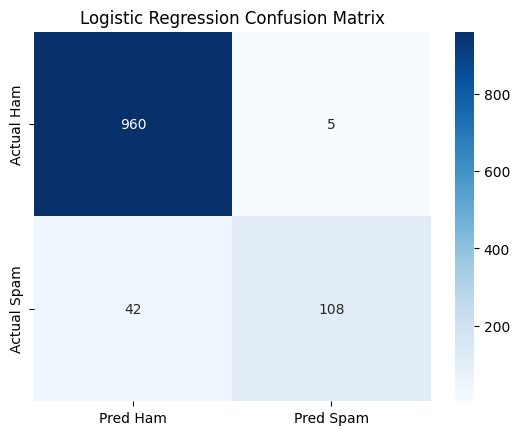


Confusion Matrix - SVM:
             Pred Ham  Pred Spam
Actual Ham        960          5
Actual Spam        16        134


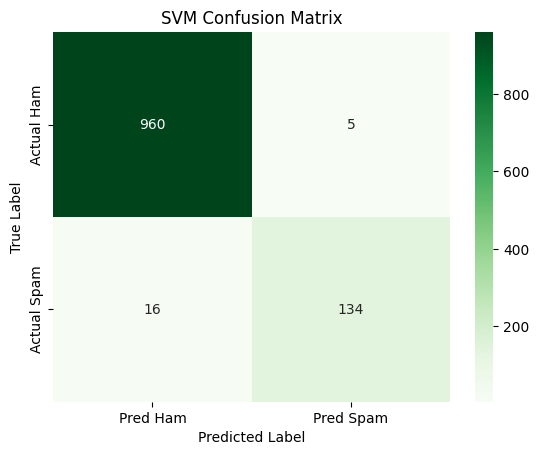

In [14]:
conf_matrix_lr = confusion_matrix(y_test, lr_preds)
conf_matrix_df_lr = pd.DataFrame(conf_matrix_lr,
                                 index=["Actual Ham", "Actual Spam"],
                                 columns=["Pred Ham", "Pred Spam"])
print("Confusion Matrix - Logistic Regression:")
print(conf_matrix_df_lr)


sns.heatmap(conf_matrix_df_lr, annot=True, cmap="Blues", fmt="d")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

conf_matrix_svm = confusion_matrix(y_test, svm_preds)
conf_matrix_df_svm = pd.DataFrame(conf_matrix_svm,
                                  index=["Actual Ham", "Actual Spam"],
                                  columns=["Pred Ham", "Pred Spam"])
print("\nConfusion Matrix - SVM:")
print(conf_matrix_df_svm)

sns.heatmap(conf_matrix_df_svm, annot=True, cmap="Greens", fmt="d")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##**Step 7: Evaluation**
We evaluate the models using accuracy, F1-score, and confusion matrices. These metrics help us understand how well the model identifies spam while minimizing false positives and false negatives.


In [11]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation Report")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, lr_preds)
evaluate_model("SVM (Tuned)", y_test, svm_preds)


Logistic Regression Evaluation Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       965
           1       0.96      0.72      0.82       150

    accuracy                           0.96      1115
   macro avg       0.96      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
[[960   5]
 [ 42 108]]

SVM (Tuned) Evaluation Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
[[960   5]
 [ 16 134]]


## **Final Discussion & Recommendation**

Best Model:

Tuned SVM achieved higher recall and precision, reducing false negatives which are critical for fraud detection.

Business Value:

Enables real-time spam filtering and fraud alerting in customer support channels.

Limitations:

Current model trained only on SMS. Contextual deep models like BERT may improve performance.

---

**Logistic Regression – Performance Overview**

Accuracy: 96% — very good, so the model is correct most of the time.

Spam accuracy: 0.96 — the model is correct 96% of the time when it states a message is spam.

Spam recall: 0.72 — indicates the issue with the model: it discovers just 72% of actual spam messages.

This indicates that 28% of spam messages remain unblocked — this is a potential threat for a financial services institution.

F1-score (spam): 0.82 — indicates how well precision and recall cooperate with each other. This is an excellent score but is negatively influenced by recall.  

Model correctly classified 108 spam messages, but 42 were missed by the model

Only 5 legitimate messages were incorrectly labeled as spam that means a low false positive rate

Logistic Regression performs well in backtesting, but due to its low recall on spam, it may miss too many threats in the real world. It is excellent at not pestering users with false alarms, but risky if failing to identify spam causes serious issues.

---

**SVM (Tuned) – Performance Overview**

Accuracy: 98% — slightly better than logistic regression, which is already excellent.

Spam accuracy: 0.96 — again excellent. It performs with high precision but still makes some errors

Spam recall: 0.89 — in this case, SVM performs much better. It can identify 89% of all spam messages.

SVM misses fewer threats and correctly stops nearly 9 out of every 10 spam attempts.

F1-score (spam): 0.93 — the model is good at identifying spam messages and makes errors rarely, so it can be relied upon.

134 actual spam messages were discovered, and 16 were missed.  
960 ham messages were accurately identified same as LR.  
There were just 5 false positives,ham incorrectly labeled as spam, the same as LR.

The tuned SVM misses fewer spam messages (false negatives) and maintains a low false positive rate

It is a preferable choice when failing to detect spam results in severe issues, such as fraud, phishing, or impersonating a customer.

Logistic Regression is simpler and faster to train, making it suitable when computational efficiency is a priority.

SVM is slightly more complex, but it provides improved **recall** and overall balance, and hence it suits business applications that require risk detection better.

**In finance, high recall matters — catching more spam reduces the risk of fraud.**

Thats why, SVM is the ideal model to deploy according to this analysis


**Model Selection Justification**

When selecting machine learning models to classify text, data type and algorithm matter. In my project, I am dealing with SMS messages and converting them into TF-IDF vectors. These are unique numerical representations of text and contain a lot of words for each message but have a majority of zeros for any particular example.

In this configuration, I chose two models that perform well with sparse, high-dimensional data:

Logistic Regression and Support Vector Machines.


I describe here why they were such a good fit:

**Logistic Regression**

Despite the fact that its name contains the word regression, Logistic Regression is actually a binary classification model— and it performs very well when used properly.

Why it works for my task:
- Handles sparse data well: The TF-IDF vectors contain lots of zeros, and logistic regression handles that very well.
- Efficient and easy to interpret: It is not expensive to train and it provides us with numbers we can interpret — useful for determining which words are tightly associated with spam or ham.
- Baseline standard: Logistic regression is usually the first algorithm that is applied to most real-world NLP problems since it performs well and is straightforward to implement.
- Why make it more complex? I am not attempting to fully grasp meanings,such as situation-shaped feelings, and our data is not ambiguous. Logistic regression offers simpleness, quickness, and dependability.

**Support Vector Machine (SVM)**

SVMs, particularly when with the linear kernel,as I used, are well-suited for problems with lots of dimensions to be classified. They were originally developed to assist with tasks such as text classification.

Why it works for what I need?:
- Tackles challenging spaces: Most standard models struggle with a large number of word features from TF-IDF, but SVMs don't.
- Facilitates separation: SVM determined the optimal hyperplane that can best differentiate between ham and spam. In a case such as this, where false positives and false negatives minimization is of great significance.
- Regularization strength: We can prevent overfitting and underfitting by altering the C parameter of GridSearchCV — useful in text data.
- Additional: SVMs make no assumption regarding how the data is distributed. This is useful since our features (TF-IDF) are not normally distributed; they are sparse and weighted.


#Conclusion

I completed the project to demonstrate that I get the entire NLP process — from loading data, to data cleaning, to model building and model checking. I kept it easy and practical.

I did not employ complex neural networks or transformer-based models. I made it simple and employed strong models known to perform well on this type of problem. If I had extra time and strong graphics cards, I would attempt to employ BERT or experiment with ensemble methods.

Currently, I believe application of SVM with TF-IDF scaling is a good approach to detecting scam messages in financial services.